In [26]:
import higra as hg 
import numpy as np 
import numpy.ma as ma 

from pprint import pformat
import inspect
import tempfile
from pathlib import Path

import idefix 
from idefix.vxl import get_grid, bin, squash, fit_bbox 
from idefix.io import load_las 
from idefix.helpers import interpolate 
from idefix.utils import *

import sap
from sap.utils import * 

import matplotlib.pyplot as plt

In [35]:
from custom_maxtree import *

# Testing structural parameter extraction using MaxTree attributes: 

**Reading pointcloud**

In [28]:
las = load_las('../pc_data/ts3_clip.las')

In [29]:
las = las[(las.spatial[..., -1] > 4) & (las.spatial[..., -1] < 25)]

In [30]:
z_min = np.min(las.spatial[..., -1])
z_max = np.max(las.spatial[..., -1])
h_exp = z_max - z_min 
print(f"The expected tree height is equal to {h_exp:.2f}m.".format(h_exp))

The expected tree height is equal to 9.95m.


**Voxelization**. Using only the point density as value for voxels. 

In [31]:
grid_space = 1
bbox = fit_bbox(las.spatial) 
grid = get_grid(bbox, grid_space) 
#fval = getattr(las.feature, 'intensity')
#vxl = bin(grid, las.spatial, fval, 'mean') 
vxl = bin(grid, las.spatial, 'density')
# vxl

**Display input voxel array** 

In [32]:
from mayavi import mlab
mlab.init_notebook()

Notebook initialized with ipy backend.


In [33]:
mlab.clf()
idefix.vxl.plot(vxl)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

In [34]:
mlab.clf()

**Calculating voxel height based on voxel index** 

In [12]:
x, y, z = vxl.shape

In [13]:
# Height based on index in Z
z_indices = np.arange(z).reshape(1, 1, z)
z_indices = z_indices + grid_space
z_array = np.broadcast_to(z_indices, (x, y, z)) 
z_values = z_array.flatten() # Flatten the values to match shape of MaxTree leaves
z_values = z_values * grid_space # Scale values to match voxel extend 

**MaxTree creation**. Using a adjacency of 6. 

In [14]:
# Tree creation 
t = MaxTree(vxl, adjacency=6)
t

MaxTree{'adjacency': 6,
 'image.dtype': dtype('float64'),
 'image.shape': (44, 59, 10),
 'image_hash': '952a2dee',
 'image_name': None,
 'num_nodes': 27105}

**Creation of additional attributes**. This being height, extent ... 

In [15]:
# Shape of the following arrays == #nodes 
max_values = hg.accumulate_sequential(t._tree, z_values, hg.Accumulators.max)
min_values = hg.accumulate_sequential(t._tree, z_values, hg.Accumulators.min)
height = max_values - min_values 

In [16]:
len(height) == t.num_nodes()

True

<Axes: >

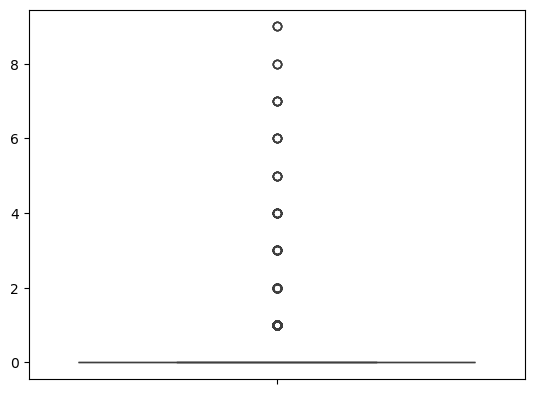

In [17]:
import seaborn as sns 
sns.boxplot(height)

**Reconstruction of tree/Structural element derivation**. 

In [18]:
volume = t.get_attribute('volume')

<Axes: >

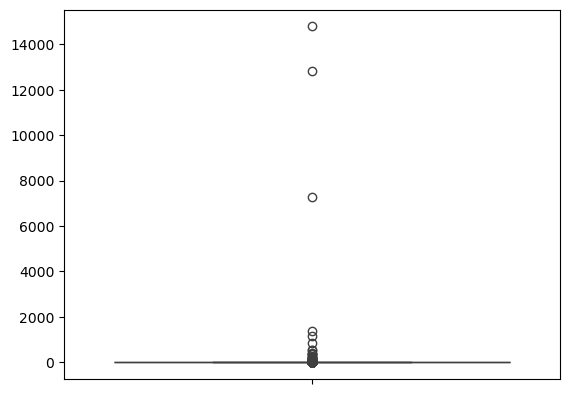

In [19]:
sns.boxplot(volume)

In [20]:
# Reconstruction based on height 
rec = t.reconstruct((height < 8) & (height > 2))

In [21]:
# Created masked array from reconstructed based on 0 values after reconstruction  
rec = ma.masked_equal(rec, 0)

In [22]:
mlab.clf()
idefix.vxl.plot(rec)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

In [23]:
mlab.clf()

In [24]:
masked_before = vxl.mask[vxl.mask == True].size/vxl.size
masked_after = rec.mask[rec.mask == True].size/vxl.size
print(f"Before filtering and reconstructing {masked_before*100:.2f}% of the voxelspace was masked.\nAfter reconstructing {masked_after*100:.2f}% of the space was masked.".format(masked_before, masked_after))

Before filtering and reconstructing 78.94% of the voxelspace was masked.
After reconstructing 79.78% of the space was masked.
